To-do:
- Make sure all libraries in for 3D -> 1D pharmacophore graph
- As in matrix calculations
- Network X

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolAlign
from rdkit.Chem.Draw import MolsToGridImage
from pharmacophore import Pharmacophore, Draw, View

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import networkx as nx



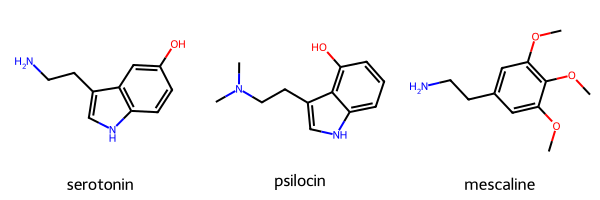

In [3]:
molecules = {"serotonin": "C1=CC2=C(C=C1O)C(=CN2)CCN",
             "psilocin": "CN(C)CCc1c[nH]c2cccc(O)c12",
             "mescaline": "O(c1cc(cc(OC)c1OC)CCN)C"}

mol_smi = [smi for smi in molecules.values()]
mol_name = [name for name in molecules.keys()]
mols = [Chem.MolFromSmiles(smi) for smi in mol_smi]

MolsToGridImage(mols=mols, legends=mol_name)

In [4]:
mols = [Chem.AddHs(mol) for mol in mols]
ps = AllChem.ETKDGv3()
ps.randomSeed = 5
for mol in mols:
    AllChem.EmbedMolecule(mol, ps)

In [5]:
aligned = []

for mol in mols:
    mol_aligned = rdMolAlign.GetO3A(mol, mols[0])
    aligned.append(mol_aligned.Align())

In [6]:
# conformations stored as sdf files
# this is step 1
for mol, name in zip(mols, mol_name):
    w = Chem.SDWriter(f"data/{name}.sdf")
    w.write(mol)
    w.close()

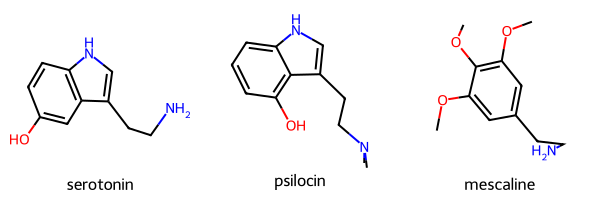

In [7]:
mols_noH = [Chem.RemoveHs(mol) for mol in mols]
MolsToGridImage(mols=mols_noH, legends=mol_name)

In [8]:
# test default and rdkit pharmacophore features: "default" and "rdkit"
PHARM_FEATURES = "rdkit"
pharm = Pharmacophore(features=PHARM_FEATURES)

# can test this also -- presence/absence of pharmacophore features
# simply binarized
df = pharm.to_df(mols_noH, mol_name=mol_name)
df

,serotonin,psilocin,mescaline
Donor,3,3,1
Acceptor,1,1,3
PosIonizable,1,1,1
Aromatic,2,2,1
Hydrophobe,3,3,2
LumpedHydrophobe,1,1,1


[['Donor', (13,), 2.0426386937709027, -1.4890329715475348, 1.2092550398315267], ['Acceptor', (0,), -2.615830241341224, 0.6586622081819367, 1.0866276156009447], ['Acceptor', (6,), 0.13188702996256887, 3.6113934629348177, -1.462378832925321], ['Acceptor', (9,), -2.0430474328930806, 3.1384109158366926, 0.08637058860151152], ['PosIonizable', (13,), 2.0426386937709027, -1.4890329715475348, 1.2092550398315267], ['Aromatic', (1, 2, 3, 4, 5, 8), -0.3533744411373463, 1.057197650843848, -0.5009222488126747], ['Hydrophobe', (3,), 0.5069691906472905, 0.009457785519939033, -0.8029736983090402], ['Hydrophobe', (11,), 1.4349337934966897, -1.1022766493840264, -1.1334201613604429], ['LumpedHydrophobe', (1, 2, 3, 4, 5, 8), -0.3533744411373463, 1.057197650843848, -0.5009222488126747]]
[[array(['Donor', 'PosIonizable'], dtype=object), (13,), np.float64(2.0426386937709027), np.float64(-1.4890329715475348), np.float64(1.2092550398315267)], [array(['Acceptor'], dtype=object), (0,), np.float64(-2.615830241341

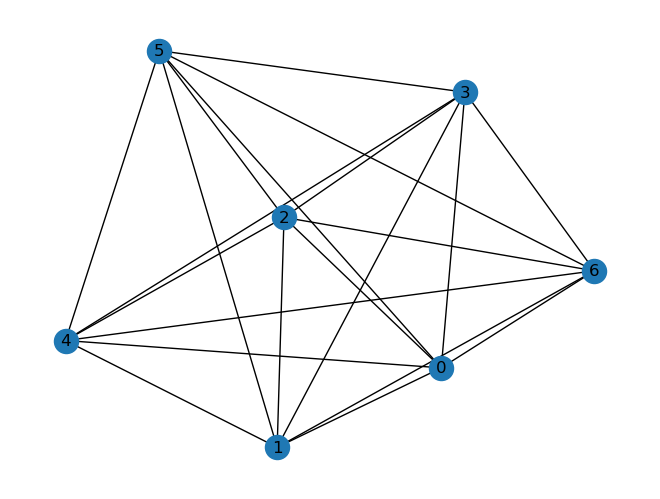

In [ ]:
pharma_single = pharm.calc_pharm(mols_noH[2])

def condense_features(pharma):
    pharma_arr = np.array(pharma, dtype=object)
    condensed_pharma = []
    atom_index = pharma_arr[:, 1]
    grouped = pd.Series(range(len(atom_index))).groupby(atom_index, sort=False).apply(list).tolist()
        
    for group in grouped:
        features = pharma_arr[group, 0]
        x_coords = pharma_arr[group, 2].astype(float)[0]
        y_coords = pharma_arr[group, 3].astype(float)[0]
        z_coords = pharma_arr[group, 4].astype(float)[0]
        condensed_pharma.append([features, atom_index[group[0]], x_coords, y_coords, z_coords])
    
    return condensed_pharma

def distance_matrix_pharma(condensed_pharma):
    cond_pharma_arr = np.array(condensed_pharma, dtype=object)
    coords = cond_pharma_arr[:, 2:5].astype(float)
    dist_matrix = distance_matrix(coords, coords)
    return dist_matrix

def pharma_nx_graph(condensed_pharma, dist_matrix):
    G = nx.Graph()
    for feature_point_indx in range(len(condensed_pharma)):
        feature_dict = {}
        for feature_indx, feature in enumerate(condensed_pharma[feature_point_indx][0]):
            feature_dict[feature_indx] = feature        
        G.add_nodes_from([(feature_point_indx, feature_dict)])
    for i in range(len(dist_matrix)):
        for j in range(i+1, len(dist_matrix)):
            G.add_edge(i, j, weight=dist_matrix[i][j])
    return G
    

print(pharma_single)  
condense_features(pharma_single)
condensed_pharma = condense_features(pharma_single)
print(condensed_pharma)
dist_matrix = distance_matrix_pharma(condensed_pharma)
nx_graph = pharma_nx_graph(condensed_pharma, dist_matrix)
print(nx_graph.nodes(data=True))
print(nx_graph.edges(data=True))

# color network by feature type
nx.draw(nx_graph, with_labels=True, )

In [ ]:
v=View()
pharma = []
for mol in mols_noH:
    pharma.append(pharm.calc_pharm(mol))
v.view(mols_noH, pharma, labels=True)

# next is networkx of flat pharmacophore

interactive(children=(Dropdown(description='Select:', options=(('Molecule 1', 0), ('Molecule 2', 1), ('Molecul…

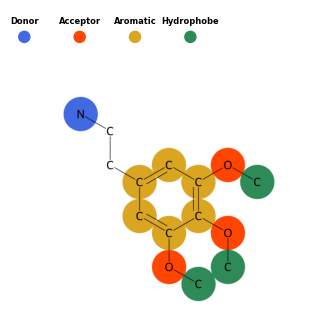

In [20]:
draw = Draw()
draw.draw_pharm(mols_noH[2])